# Polars Tutorial Part 3

https://www.youtube.com/watch?v=UbcKZKPXhDA&list=PLo9Vi5B84_dfAuwJqNYG4XhZMrGTF3sBx&index=4

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pandas as pd
import pyarrow
import seaborn as sns

In [2]:
data_file = "/Users/alex/.cache/kagglehub/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store/versions/8/2019-Nov.csv"
df = pl.read_csv(data_file)

### 1. Groupby - pl.count (one group)

In [5]:
# groupby -> group_by
# pl.count() -> pl.len()

df.group_by("brand").agg([
    pl.len()
]).head()

brand,len
str,u32
"""meccano""",6
"""pika""",71
"""magellan""",2199
"""traxxas""",268
"""interskol""",82


In [16]:
# sort(..., reverse=...) => sort(..., descending=...)

# sorting an aggregation
df.group_by("brand").agg([
    pl.len() 
]).sort("len", descending=True).head()


brand,len
str,u32
null,9218235
"""samsung""",7889245
"""apple""",6259379
"""xiaomi""",4638062
"""huawei""",1410126


In [19]:
# compute count and percent of instances
(df.group_by("brand")
    .agg([ pl.len() ])
    .sort("len", descending=True)
    .with_columns([
        (pl.col("len") / pl.col("len").sum()).alias("n_pct")
    ])
    .head()
)

brand,len,n_pct
str,u32,f64
null,9218235,0.136562
"""samsung""",7889245,0.116874
"""apple""",6259379,0.092729
"""xiaomi""",4638062,0.06871
"""huawei""",1410126,0.02089


#### value counts works as expected

In [22]:
#df["event_type"].value_counts()

# more idiomatically in polars, and faster as well
df.group_by("event_type").agg(pl.len())

event_type,len
str,u32
"""cart""",3028930
"""view""",63556110
"""purchase""",916939


### 2. Groupby - pl.len (two groups)

In [26]:
df_brand_event = df.group_by(["brand", "event_type"]).agg([
    pl.len()
])
# long format
df_brand_event.head()

brand,event_type,len
str,str,u32
"""awei""","""cart""",285
"""blaupunkt""","""view""",9674
"""olto""","""purchase""",70
"""naturehike""","""cart""",53
"""sariel""","""cart""",9


In [28]:
# pivot(..., columns=...) => pivot(..., on=...)

# pivot to wide format
df_brand_event_wide = df_brand_event.pivot(
    values="len",
    index=["brand"],
    on=["event_type"],
)

df_brand_event_wide.head()

brand,cart,view,purchase
str,u32,u32,u32
"""awei""",285,7152,65
"""blaupunkt""",267,9674,54
"""olto""",204,4690,70
"""naturehike""",53,5024,17
"""sariel""",9,721,4


In [40]:
# nulls are always sorted first unless you explicitly
# place them last in polars

# pivot and sorting
df_brand_event_wide = (
    df_brand_event
    .pivot(
        values="len",
        index=["brand"],
        on=["event_type"],
    )
    .sort("purchase", descending=True, nulls_last=True)
)

df_brand_event_wide.head()

brand,cart,view,purchase
str,u32,u32,u32
"""samsung""",597220,7091998,200027
"""apple""",489665,5603650,166064
null,258242,8886720,73273
"""xiaomi""",260019,4309751,68292
"""huawei""",73760,1312663,23703


In [49]:
# compute % values
agg_performance = df_brand_event_wide.with_columns([
    (pl.col("cart") / pl.col("view")).alias("cart_by_views"),
    (pl.col("purchase") / pl.col("cart")).alias("buy_by_cart"),
    (pl.col("purchase") / pl.col("view")).alias("buy_by_views"),
])

agg_performance.head()

brand,cart,view,purchase,cart_by_views,buy_by_cart,buy_by_views
str,u32,u32,u32,f64,f64,f64
"""samsung""",597220,7091998,200027,0.08421,0.33493,0.028205
"""apple""",489665,5603650,166064,0.087383,0.339138,0.029635
null,258242,8886720,73273,0.029059,0.283738,0.008245
"""xiaomi""",260019,4309751,68292,0.060333,0.262642,0.015846
"""huawei""",73760,1312663,23703,0.056191,0.321353,0.018057


In [59]:
(agg_performance
    .filter(pl.col("buy_by_cart") < 1)
    .select(["cart_by_views", "buy_by_cart", "buy_by_views"])
    .to_pandas().quantile([0., 0.25, 0.5, 0.75, 0.99, 1])
)

,cart_by_views,buy_by_cart,buy_by_views
0.00,0.001115,0.026810,0.000353
0.25,0.014640,0.210685,0.003704
0.50,0.024419,0.279579,0.006616
0.75,0.037220,0.343597,0.010874
0.99,0.121112,0.750000,0.043861
1.00,0.400000,0.900000,0.200000


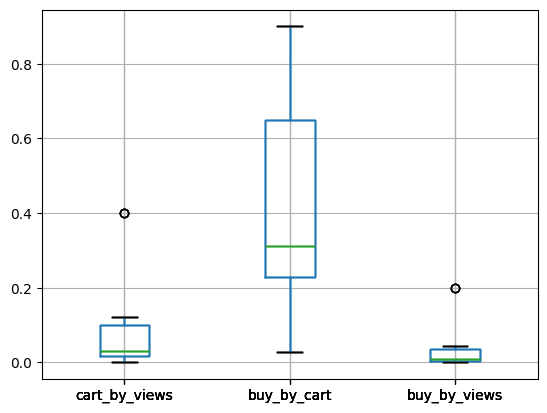

In [63]:
(agg_performance
    .filter(pl.col("buy_by_cart") < 1)
    .select(["cart_by_views", "buy_by_cart", "buy_by_views"])
    .to_pandas()
    .quantile([0., 0.25, 0.5, 0.75, 0.99, 1])
    .boxplot()
)
plt.show()

### 3. groupby - userid + 2 groups

In [65]:
%%time

df_user_brand_event = (
    df
    .group_by([ "user_id", "brand", "event_type" ])
    .agg([ pl.len() ])
)
df_user_brand_event.head()

CPU times: user 12.5 s, sys: 16.2 s, total: 28.7 s
Wall time: 23.5 s


user_id,brand,event_type,len
i64,str,str,u32
522966477,"""cifyurm""","""view""",1
513589296,"""tp-link""","""view""",1
514214661,"""navitel""","""view""",3
518685340,"""sonel""","""cart""",1
518661997,"""samsung""","""view""",22


In [66]:
df_user_brand_event.shape

(17798395, 4)

In [68]:
# pivot and sort
df_user_brand_event = (
    df_user_brand_event
    .pivot(
        values="len",
        index=["user_id", "brand"],
        on=["event_type"],
    )
    .sort("purchase", descending=True, nulls_last=True)
)
df_user_brand_event.shape

(15905970, 5)

In [69]:
df_user_brand_event.head()

user_id,brand,view,cart,purchase
i64,str,u32,u32,u32
564068124,"""samsung""",634,431,453
518514099,"""apple""",314,206,190
549030056,"""samsung""",313,300,180
543128872,"""apple""",239,161,154
549109608,"""samsung""",307,184,154


In [72]:
# fillna

df_user_brand_event = (
    df_user_brand_event.with_columns([
        pl.col("purchase").fill_null(strategy="zero"),
        pl.col("view").fill_null(strategy="zero"),
        pl.col("cart").fill_null(strategy="zero"),
    ])
)

In [73]:
df_user_brand_event.sample(10)

user_id,brand,view,cart,purchase
i64,str,u32,u32,u32
517460980,null,3,0,0
529314712,"""huawei""",1,0,0
569313557,"""hansa""",1,0,0
557975605,"""cordiant""",1,0,0
515204369,"""aoc""",3,0,0
512986613,"""lucente""",7,0,0
512766804,"""redmond""",2,0,0
576637087,null,1,0,0
513416930,"""tigar""",2,0,0


In [75]:
# likely resellers

df_user_brand_event.head()

user_id,brand,view,cart,purchase
i64,str,u32,u32,u32
564068124,"""samsung""",634,431,453
518514099,"""apple""",314,206,190
549030056,"""samsung""",313,300,180
543128872,"""apple""",239,161,154
549109608,"""samsung""",307,184,154


In [77]:
df_user_brand_event = (
    df_user_brand_event.with_columns(
        (pl.col("purchase") / pl.col("view")).alias("pct_buy_views")
    )
)

In [78]:
df_user_brand_event.head()

user_id,brand,view,cart,purchase,pct_buy_views
i64,str,u32,u32,u32,f64
564068124,"""samsung""",634,431,453,0.714511
518514099,"""apple""",314,206,190,0.605096
549030056,"""samsung""",313,300,180,0.57508
543128872,"""apple""",239,161,154,0.644351
549109608,"""samsung""",307,184,154,0.501629


In [84]:
# vectorized if/else to handle when pct is infinite

df_user_brand_event = (
    df_user_brand_event.with_columns(
        pl.when(pl.col("pct_buy_views").is_infinite())
                .then(None)
                .otherwise(pl.col("pct_buy_views"))      
    )
)

In [85]:
df_user_brand_event.sample(5)

user_id,brand,view,cart,purchase,pct_buy_views,literal
i64,str,u32,u32,u32,f64,f64
529775852,"""apple""",2,0,0,0.0,0.0
542203475,"""qvs""",1,0,0,0.0,0.0
532393713,"""acuvue""",7,2,0,0.0,0.0
512367870,"""luminarc""",1,0,0,0.0,0.0
570243903,"""puma""",1,0,0,0.0,0.0
